In [11]:
%matplotlib notebook
import os
import numpy as np
import matplotlib.pyplot as plt

import h5py

from models import UNet, CallBacks, DataGenerator
import tensorflow as tf
from tensorflow import keras

In [2]:
""" Setting random seeds """
from models import seed

# TensorFlow
tf.random.set_seed(seed)

# Python
import random as python_random
python_random.seed(seed)

# NumPy (random number generator used for sampling operations)
rng = np.random.default_rng(seed)

# Model set-up

In [3]:
""" Definitions/parameters """

# Number of waveforms per sampl
N_sub = 11
# Number of mini-batches
batch_size = 32

# Model name retrained on DAS data
model_name = "pretrained_f0=4_logSNR=-2_4_correct-GL"

cwd = os.getcwd()
data_dir = os.path.join(cwd, "data")
HCMR_data_file = os.path.join(data_dir, "events_HCMR.h5")
nestor_data_file = os.path.join(data_dir, "events_Nestor.h5")

""" Callbacks """

logdir = os.path.join("logs", model_name)
    
savefile = "saved-model.h5"
savedir = os.path.join("save", model_name)
if not os.path.isdir(savedir):
    os.makedirs(savedir)

tensorboard_callback = CallBacks.tensorboard(logdir)
checkpoint_callback = CallBacks.checkpoint(os.path.join(savedir, savefile))

# Load DAS data

<IPython.core.display.Javascript object>


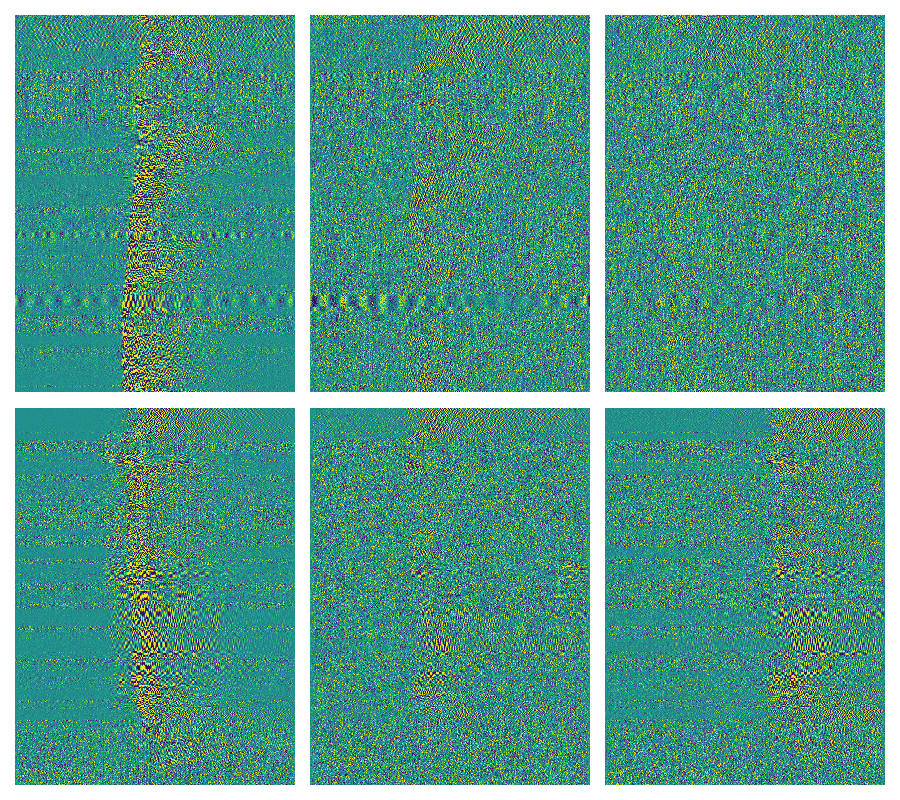

In [5]:
# Load/process HCMR_data
with h5py.File(HCMR_data_file, "r") as h5f:
    HCMR_data = h5f["strain_rate"][...]

# Normalise waveforms
for n in range(HCMR_data.shape[0]):
    for i in range(HCMR_data.shape[1]):
        HCMR_data[n, i] = HCMR_data[n, i] / HCMR_data[n, i].std()

# Load/process Nestor data
with h5py.File(nestor_data_file, "r") as h5f:
    nestor_data = h5f["strain_rate"][...]

# Normalise waveforms
for n in range(nestor_data.shape[0]):
    for i in range(nestor_data.shape[1]):
        nestor_data[n, i] = nestor_data[n, i] / nestor_data[n, i].std()
    
""" Visualise data """

# Draw canvas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 8))

# Loop over 3 selected events
for i in range(3):
    axes[0, i].imshow(HCMR_data[i], aspect="auto", vmin=-2, vmax=2, interpolation="none")
    axes[0, i].axis("off")
    
    axes[1, i].imshow(nestor_data[i], aspect="auto", vmin=-2, vmax=2, interpolation="none")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

In [6]:
# Select events for training/validation
HCMR_test_inds = [5, 10, 14, 19]
HCMR_train_inds = np.delete(np.arange(HCMR_data.shape[0]), HCMR_test_inds)

nestor_test_inds = [0, 4]
nestor_train_inds = np.delete(np.arange(nestor_data.shape[0]), nestor_test_inds)

N_ch = min(HCMR_data.shape[1], nestor_data.shape[1])

# Create training/validation data sets
train_samples = np.concatenate([HCMR_data[HCMR_train_inds, :N_ch], nestor_data[nestor_train_inds, :N_ch]], axis=0)
test_samples = np.concatenate([HCMR_data[HCMR_test_inds, :N_ch], nestor_data[nestor_test_inds, :N_ch]], axis=0)

print("Preparing masks")

# Prepare data generators
train_generator = DataGenerator(train_samples, N_sub=N_sub, batch_size=batch_size)
test_generator = DataGenerator(test_samples, N_sub=N_sub, batch_size=batch_size)

print("Done")

Preparing masks
Done


<IPython.core.display.Javascript object>


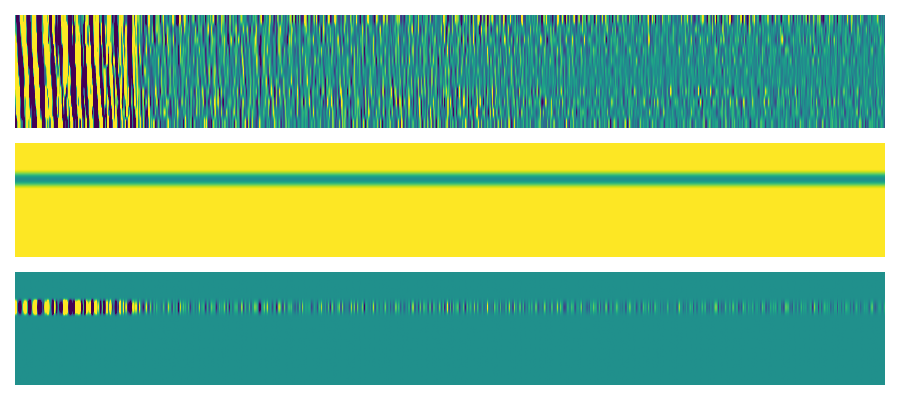

In [7]:
# Select one mini-batch sample for inspection
(samples, masks), masked_samples = test_generator.__getitem__(4)

# Draw canvas
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 4))

axes[0].imshow(samples[0, :, :, 0], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[0].axis("off")

axes[1].imshow(masks[0, :, :, 0], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[1].axis("off")

axes[2].imshow(masked_samples[0, :, :, 0], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[2].axis("off")

plt.tight_layout()
plt.show()

# Load pretrained model

In [8]:
pretrainfile = os.path.join("save", "pretrained_synthetic.h5")
model = keras.models.load_model(pretrainfile)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 11, 2048, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 11, 2048, 1) 0                                            
__________________________________________________________________________________________________
tf_op_layer_Mul_2 (TensorFlowOp (None, 11, 2048, 1)  0           input_4[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 11, 2048, 4)  64          tf_op_layer_Mul_2[0][0]    

# Continue training on DAS data

In [10]:
model.fit(
    x=train_generator,
    validation_data=test_generator,
    callbacks=[tensorboard_callback, checkpoint_callback],
    verbose=1, epochs=50,
)

Epoch 1/50
 94/230 [===========>..................] - ETA: 8s - loss: 0.0835

KeyboardInterrupt: 

# Get J-invariant reconstructions of DAS data

## HCMR

In [9]:
HCMR_reconstructions = np.zeros_like(HCMR_data)
N_samples, N_ch, N_t = HCMR_data.shape

# Loop over events in HCMR data set
for n, eval_sample in enumerate(HCMR_data):
    
    """ Prepare samples and masks """
    masks = np.ones((N_ch, N_sub, N_t, 1))
    eval_samples = np.zeros_like(masks)

    gutter = N_sub // 2
    mid = N_sub // 2

    for i in range(gutter):
        masks[i, i] = 0
        eval_samples[i, :, :, 0] = eval_sample[:N_sub]

    for i in range(gutter, N_ch - gutter):
        start = i - mid
        stop = i + mid + 1

        masks[i, mid] = 0
        eval_samples[i, :, :, 0] = eval_sample[start:stop]

    for i in range(N_ch - gutter, N_ch):
        masks[i, i - N_ch] = 0
        eval_samples[i, :, :, 0] = eval_sample[-N_sub:]
    
    """ Create J-invariant reconstructions """
    results = model.predict((eval_samples, masks))
    HCMR_reconstructions[n] = np.sum(results, axis=1)[:, :, 0]


""" Save results """ 
h5filename = "reconstructions_HCMR_retrained.h5"
h5file = os.path.join(data_dir, h5filename)

with h5py.File(h5file, "w") as h5f:
    h5f.create_dataset("strain_rate", data=HCMR_reconstructions)

1.2918108985537575


In [19]:
nestor_reconstructions = np.zeros_like(nestor_data)
N_samples, N_ch, N_t = nestor_data.shape

# Loop over events in HCMR data set
for n, eval_sample in enumerate(nestor_data):
    
    """ Prepare samples and masks """
    masks = np.ones((N_ch, N_sub, N_t, 1))
    eval_samples = np.zeros_like(masks)

    gutter = N_sub // 2
    mid = N_sub // 2

    for i in range(gutter):
        masks[i, i] = 0
        eval_samples[i, :, :, 0] = eval_sample[:N_sub]

    for i in range(gutter, N_ch - gutter):
        start = i - mid
        stop = i + mid + 1

        masks[i, mid] = 0
        eval_samples[i, :, :, 0] = eval_sample[start:stop]

    for i in range(N_ch - gutter, N_ch):
        masks[i, i - N_ch] = 0
        eval_samples[i, :, :, 0] = eval_sample[-N_sub:]
    
    """ Create J-invariant reconstructions """
    results = model.predict((eval_samples, masks))
    nestor_reconstructions[n] = np.sum(results, axis=1)[:, :, 0]

    
""" Save results """ 

h5filename = "reconstructions_Nestor_retrained.h5"
h5file = os.path.join(data_dir, h5filename)

with h5py.File(h5file, "w") as h5f:
    h5f.create_dataset("strain_rate", data=nestor_reconstructions)